## Logic Based FizzBuzz Function [Software 1.0]

In [252]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import pandas as pd
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt
from itertools import islice
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.utils import np_utils
import pickle
import gzip
from PIL import Image
import os
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report

## Processing Input and Label Data

In [253]:
clf1_m = []
clf2_m = []
clf3_m = []
clf4_m = []
clf1_u = []
clf2_u = []
clf3_u = []
clf4_u = []
filename = 'mnist.pkl.gz'
f = gzip.open(filename, 'rb')
training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
f.close()

In [254]:
USPSMat  = []
USPSTar  = []
curPath  = 'USPSdata/Numerals'
savedImg = []
for j in range(0,10):
    curFolderPath = curPath + '/' + str(j)
    imgs =  os.listdir(curFolderPath)
    for img in imgs:
        curImg = curFolderPath + '/' + img
        if curImg[-3:] == 'png':
            img = Image.open(curImg,'r')
            img = img.resize((28, 28))
            savedImg = img
            imgdata = (255-np.array(img.getdata()))/255
            USPSMat.append(imgdata)
            USPSTar.append(j)
            

In [255]:
#creating one hot vector
TrainingTarget = np.zeros((training_data[1].shape[0], 10))
TrainingTarget[np.arange(training_data[1].shape[0]), training_data[1]] = 1
TrainingData = training_data[0]
#validation data
ValDataAct = np.zeros((validation_data[1].shape[0], 10))
ValDataAct[np.arange(validation_data[1].shape[0]), validation_data[1]] = 1
ValData = validation_data[0]
#Testing datas
TestDataAct = np.zeros((test_data[1].shape[0], 10))
TestDataAct[np.arange(test_data[1].shape[0]), test_data[1]] = 1
TestData = test_data[0]
#Combining validation and Training data
TrainingData = np.vstack((TrainingData,ValData))
TrainingTarget = np.vstack((TrainingTarget,ValDataAct))

In [256]:
USPS_TestData = np.array(USPSMat)
USPS_test_target = np.array(USPSTar)
USPS_TestTarget = np.zeros((USPS_test_target.shape[0], 10))
USPS_TestTarget[np.arange(USPS_test_target.shape[0]), USPS_test_target] = 1

In [257]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):


    print ("\nConfusion Matrix\n")
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Logistic Regression

In [258]:
def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)): #computing the root mean squared error
        if(np.argmax(VAL_TEST_OUT[i]) == np.argmax(ValDataAct[i])): # classifying the regression output to three ranks 0,1,2 by rounding the y value to nearest even number
            #print(np.max(VAL_TEST_OUT[i]),np.max(ValDataAct[i]))
            counter = counter + 1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT))) #computes the ratio of correct prediction to total input
    return accuracy #accuracy 

def FindActivation(X, W):
#     print(X.shape)
#     print(W.shape)
    WX = np.dot(np.transpose(W),np.transpose(X)) #w=785*10 x=50000*785 WX=10*50000
    numerator = np.exp(WX) #10*50000 and avoid overfitting
    denom = np.sum(np.exp(WX), axis=0)#1*50000
    a = numerator/denom #softmax function #10*50000
#     print(np.shape(numerator),np.shape(denom),np.shape(a))
#     print(numerator.T[0],denom[0],a.T[0],np.sum(a.T[0]))
    return a

def LOGRModel(iter):    
    global TrainingTarget,TrainingData, ValDataAct, ValData , TestDataAct, TestData, USPS_TestData, USPS_TestTarget, clf1_m, clf1_u
    W_Now        = np.random.random((TrainingData.shape[1]+1,10))
    La           = 0.01
    learningRate = 0.1
    #AddBias
    X = np.ones((TrainingData.shape[0],1))
    TrainingData = np.hstack((TrainingData,X))
    X = np.ones((ValData.shape[0],1))
    ValData = np.hstack((ValData,X))
    X = np.ones((TestData.shape[0],1))
    TestData = np.hstack((TestData,X))
    X = np.ones((USPS_TestData.shape[0],1))
    USPS_TestData = np.hstack((USPS_TestData,X))
    print("After Adding Bias")
    print('----------TRAINING DATA--------------')
    print(TrainingTarget.shape)
    print(TrainingData.shape)
    print('---------VALIDATION DATA---------------')
    print(ValDataAct.shape)
    print(ValData.shape)
    print('----------MNIST TESTING DATA-------------')
    print(TestDataAct.shape)
    print(TestData.shape)
    print('---------- USPS TESTING DATA-------------')
    print(USPS_TestTarget.shape)
    print(USPS_TestData.shape)
    print('----------WEIGHT-------------')
    print(W_Now.shape)
    for i in range(0,iter): 
        for j in range(0, TrainingData.shape[0] - 500, 500):
            G = FindActivation(TrainingData[j:j+500], W_Now)
#             print(np.shape(G))                       
            val = np.subtract(G, np.transpose(TrainingTarget[j:j+500]))
#             print(np.shape(val)) 
            Delta_E_D = np.dot(val,TrainingData[j:j+500])/TrainingTarget[j:j+500].shape[0]
            La_Delta_E_W  = np.dot(La,W_Now) # Error regularization
            Delta_E       = np.add(np.transpose(Delta_E_D),La_Delta_E_W)  # adding regularization to gradient error
            Delta_W       = -np.dot(learningRate,Delta_E) # multipying learning rate to computed error
            W_T_Next      = W_Now + Delta_W # subtracting error from output
            W_Now         = W_T_Next # updating the weight
    #         print(W_Now)
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = FindActivation(TrainingData,W_T_Next) #10*10000
    acc_tr = GetErms(np.transpose(TR_TEST_OUT),TrainingTarget) #10000*10
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = FindActivation(ValData,W_T_Next) 
    acc_val = GetErms(np.transpose(VAL_TEST_OUT),ValDataAct)
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = np.transpose(FindActivation(TestData,W_T_Next))
    acc_test = GetErms(TEST_OUT,TestDataAct) 
    #-----------------USPS TestingData Accuracy---------------------#
    TEST_OUT_USPS      = np.transpose(FindActivation(USPS_TestData,W_T_Next))
    acc_test_usps = GetErms(TEST_OUT_USPS,USPS_TestTarget)
    print ('\n----------Gradient Descent Solution--------------------')
    print('learning rate %s' % learningRate)
    print('Lambda %s' % La)
    print ("Accuracy Training   = " + str(np.around(acc_tr,5)))
    print ("Accuracy Validation = " + str(np.around(acc_val,5)))
    print ("Accuracy Testing  MNIST  = " + str(np.around(acc_test,5)))
    print ("Accuracy Testing USPS   = " + str(np.around(acc_test_usps,5)))
    print(np.shape(np.argmax(TEST_OUT, axis = 1)))
    clf1_m = np.argmax(TEST_OUT, axis = 1)
    cm = confusion_matrix(test_data[1], np.argmax(TEST_OUT, axis = 1))
    plt.figure()
    plot_confusion_matrix(cm, classes=np.arange(10),
                          title='LR - Confusion matrix Mnist')
    plt.show()
    print(classification_report(test_data[1], np.argmax(TEST_OUT, axis = 1)))
    clf1_u = np.argmax(TEST_OUT_USPS, axis = 1)
    cm = confusion_matrix(USPS_test_target, np.argmax(TEST_OUT_USPS, axis = 1))
    plt.figure()
    plot_confusion_matrix(cm, classes=np.arange(10),
                          title='LR - Confusion matrix USPS')
    plt.show()
    print(classification_report(USPS_test_target, np.argmax(TEST_OUT_USPS, axis = 1)))

## Neural Networks

In [259]:
def get_model():
    input_size = TrainingData.shape[1]
    drop_out = 0.3
    first_dense_layer_nodes  = 200
    final_dense_layer_nodes = 10
    second_dense_layer_nodes  = 100
    # Why do we need a model?
    # Why use Dense layer and then activation?
    # Why use sequential model with layers?
    model = Sequential()
    
    model.add(Dense(first_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('relu'))
    
    # Why dropout?
    model.add(Dropout(drop_out))
    
    model.add(Dense(second_dense_layer_nodes))
    model.add(Activation('relu'))
    
    model.add(Dropout(drop_out))
    
    model.add(Dense(final_dense_layer_nodes))
    model.add(Activation('softmax'))
    # Why Softmax?
    
    model.summary()
    
    # Why use categorical_crossentropy?
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

def TrainModel(iter):
    global clf2_m, clf2_u
    model = get_model()
    validation_data_split = 0.2
    num_epochs = iter
    model_batch_size = 211
    tb_batch_size = 32
    early_patience = 100

    tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
    earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')


    # Process Dataset
    processedData= TrainingData
    print(processedData.shape)
    processedLabel = TrainingTarget
    print(processedLabel.shape)

    history = model.fit(processedData
                        , processedLabel
                        , validation_split=validation_data_split
                        , epochs=num_epochs
                        , batch_size=model_batch_size
                        , callbacks = [tensorboard_cb,earlystopping_cb]
                       )
    loss,accuracy = model.evaluate(TestData,TestDataAct)
    print("\nMnist Results\n")
    print("loss,accuracy = " + str(loss) + " , " + str(accuracy * 100))
    y_pred_mnist = model.predict_classes(TestData)
    clf2_m = y_pred_mnist
    cm = confusion_matrix(test_data[1], y_pred_mnist)
    plt.figure()
    plot_confusion_matrix(cm, classes=np.arange(10),
                          title='NN - Confusion matrix Mnist')
    plt.show()
    print(classification_report(test_data[1], y_pred_mnist))
    print("\nUSPS Results\n")
    loss,accuracy = model.evaluate(USPS_TestData,USPS_TestTarget)
    print("loss,accuracy = " + str(loss) + " , " + str(accuracy * 100))
    y_pred_usps = clf2_u = model.predict_classes(USPS_TestData)
    cm = confusion_matrix(USPS_test_target, y_pred_usps)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes=np.arange(10),
                          title='NN - Confusion matrix USPS')
    plt.show()
    print(classification_report(USPS_test_target, y_pred_usps))
    return history

def nn_main():
    history = TrainModel(20)
    df = pd.DataFrame(history.history)
    df.plot(subplots=True, grid=True, figsize=(10,15))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 200)               157000    
_________________________________________________________________
activation_67 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 100)               20100     
_________________________________________________________________
activation_68 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 10)                1010      
__________

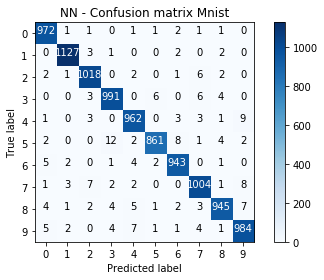

             precision    recall  f1-score   support

          0       0.98      0.99      0.99       980
          1       0.99      0.99      0.99      1135
          2       0.98      0.99      0.98      1032
          3       0.98      0.98      0.98      1010
          4       0.98      0.98      0.98       982
          5       0.99      0.97      0.98       892
          6       0.98      0.98      0.98       958
          7       0.98      0.98      0.98      1028
          8       0.98      0.97      0.98       974
          9       0.97      0.98      0.97      1009

avg / total       0.98      0.98      0.98     10000


USPS Results

19999/19999 [==============================] - 0s 17us/step
loss,accuracy = 6.70673886743377 , 41.35206760293311

Confusion Matrix

[[ 478    8  346   65  234  125  222  259   57  206]
 [  36  329  566   82  553   66   19  157  145   47]
 [  47    3 1619   46   25   58   97   56   44    4]
 [  11    2  455 1211    6  214   34   30   23   14]
 [

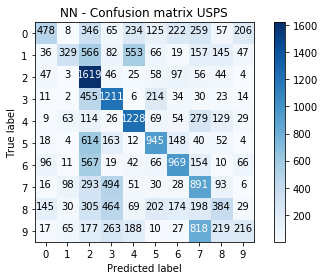

             precision    recall  f1-score   support

          0       0.55      0.24      0.33      2000
          1       0.54      0.16      0.25      2000
          2       0.32      0.81      0.46      1999
          3       0.43      0.61      0.50      2000
          4       0.51      0.61      0.56      2000
          5       0.53      0.47      0.50      2000
          6       0.55      0.48      0.51      2000
          7       0.31      0.45      0.37      2000
          8       0.33      0.19      0.24      2000
          9       0.35      0.11      0.16      2000

avg / total       0.44      0.41      0.39     19999



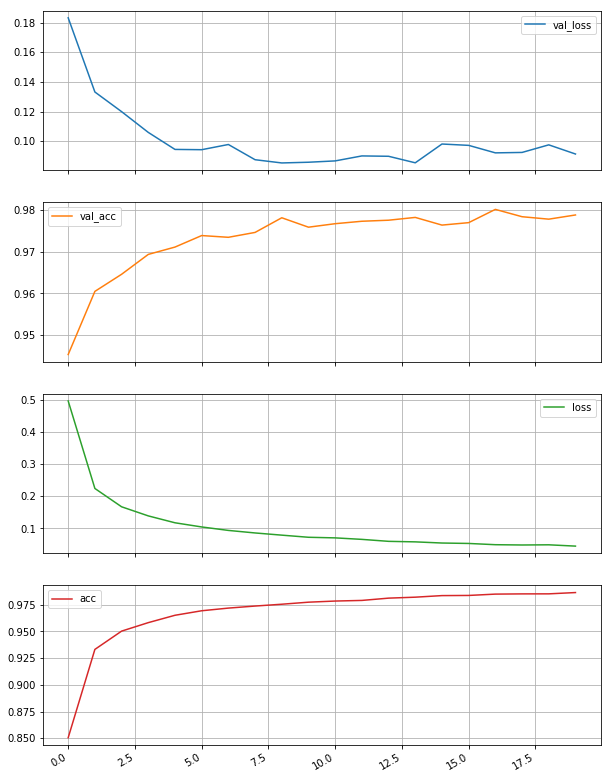

In [260]:
nn_main()

# RandomForestClassifier

Random Forest Results

Mnist Results

Accuracy = 94.44

Confusion Matrix

[[ 968    0    2    1    0    2    2    1    4    0]
 [   0 1120    1    2    1    2    4    1    4    0]
 [   8    0  982    9    4    4    3   13    9    0]
 [   0    3   16  953    0   16    1   10    9    2]
 [   4    5    7    3  923    1    7    2    2   28]
 [   7    2    3   31    6  823    6    2    7    5]
 [  10    4    4    0    8   12  917    1    2    0]
 [   1    6   27   10    5    0    0  957    3   19]
 [   4    2   18   26    9   13    4    2  883   13]
 [   6    6    3   16   26    7    1    9   17  918]]


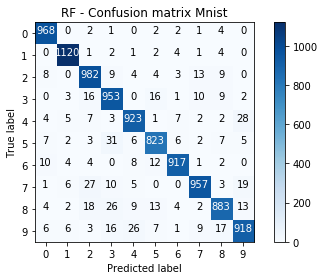

             precision    recall  f1-score   support

          0       0.96      0.99      0.97       980
          1       0.98      0.99      0.98      1135
          2       0.92      0.95      0.94      1032
          3       0.91      0.94      0.92      1010
          4       0.94      0.94      0.94       982
          5       0.94      0.92      0.93       892
          6       0.97      0.96      0.96       958
          7       0.96      0.93      0.94      1028
          8       0.94      0.91      0.92       974
          9       0.93      0.91      0.92      1009

avg / total       0.94      0.94      0.94     10000


USPS Results

Accuracy = 30.041502075103754

Confusion Matrix

[[ 615   52  350  122  245  190   82  115   26  203]
 [  70  513  205  121   61  103   42  845   31    9]
 [ 250  106  919  137   59  222   53  209   29   15]
 [ 120   66  200 1013   49  359   11  124   23   35]
 [  48  254  122  127  822  182   30  327   35   53]
 [ 195   73  249  245   45  984 

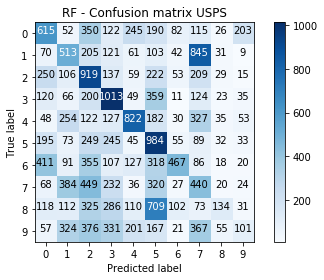

             precision    recall  f1-score   support

          0       0.32      0.31      0.31      2000
          1       0.26      0.26      0.26      2000
          2       0.26      0.46      0.33      1999
          3       0.37      0.51      0.43      2000
          4       0.47      0.41      0.44      2000
          5       0.28      0.49      0.35      2000
          6       0.52      0.23      0.32      2000
          7       0.16      0.22      0.19      2000
          8       0.33      0.07      0.11      2000
          9       0.19      0.05      0.08      2000

avg / total       0.32      0.30      0.28     19999



In [261]:
from sklearn.ensemble import RandomForestClassifier
classifier2 = RandomForestClassifier(n_estimators=10);
classifier2.fit(training_data[0], training_data[1])
y_pred = clf3_m = classifier2.predict(test_data[0])
y_pred_usps = clf3_u = classifier2.predict(USPS_TestData)
print("Random Forest Results")

print("\nMnist Results\n")
print("Accuracy = " + str(classifier2.score(test_data[0],test_data[1]) * 100))
cm = confusion_matrix(test_data[1], y_pred )
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=np.arange(10),
                      title='RF - Confusion matrix Mnist')
plt.show()
print(classification_report(test_data[1], y_pred ))
print("\nUSPS Results\n")
print("Accuracy = " + str(classifier2.score(USPS_TestData,USPS_test_target) * 100))
cm = confusion_matrix(USPS_test_target, y_pred_usps)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=np.arange(10),
                      title='RF - Confusion matrix USPS')
plt.show()
print(classification_report(USPS_test_target, y_pred_usps))

# SVM

SVM Results

Mnist Results

Accuracy = 96.65

Confusion Matrix

[[ 966    0    3    0    0    2    6    1    2    0]
 [   0 1123    3    2    0    1    3    0    3    0]
 [   4    0 1003    3    1    0    3    6   12    0]
 [   0    0   12  973    0    6    0    8    9    2]
 [   0    0    6    0  953    0    8    1    3   11]
 [   3    0    7   14    1  852    5    1    8    1]
 [   6    3    4    0    5    2  935    0    3    0]
 [   0    7   22    3    6    0    0  976    3   11]
 [   6    0    3   13    5    4    0    3  937    3]
 [   5    5    4    6   20    1    0    6   15  947]]


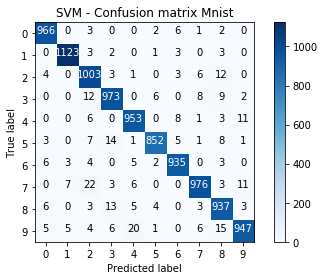

             precision    recall  f1-score   support

          0       0.98      0.99      0.98       980
          1       0.99      0.99      0.99      1135
          2       0.94      0.97      0.96      1032
          3       0.96      0.96      0.96      1010
          4       0.96      0.97      0.97       982
          5       0.98      0.96      0.97       892
          6       0.97      0.98      0.97       958
          7       0.97      0.95      0.96      1028
          8       0.94      0.96      0.95       974
          9       0.97      0.94      0.95      1009

avg / total       0.97      0.97      0.97     10000


USPS Results

Accuracy = 20.981049052452622

Confusion Matrix

[[ 187    0 1665    2   36   13    2    1   60   34]
 [  65  159  755  167  336   76   11  241  181    9]
 [   9    0 1933    9    7   11    2    9   19    0]
 [   3    0 1417  544    0   18    0    0   18    0]
 [   7    0 1240   20  406   33    0   43  250    1]
 [   7    0 1574   38    1  343 

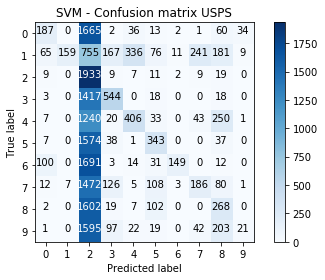

             precision    recall  f1-score   support

          0       0.48      0.09      0.16      2000
          1       0.96      0.08      0.15      2000
          2       0.13      0.97      0.23      1999
          3       0.53      0.27      0.36      2000
          4       0.49      0.20      0.29      2000
          5       0.45      0.17      0.25      2000
          6       0.89      0.07      0.14      2000
          7       0.36      0.09      0.15      2000
          8       0.24      0.13      0.17      2000
          9       0.32      0.01      0.02      2000

avg / total       0.48      0.21      0.19     19999



In [262]:
from sklearn.svm import SVC
X_train = training_data[0][0:10000]
Y_train = training_data[1][0:10000]
Mnist_test = test_data[0]
Usps_test = USPS_TestData
classifier1 = SVC(kernel='rbf', C=2, gamma = 0.05);
classifier1.fit(X_train, Y_train)
y_pred = clf4_m = classifier1.predict(Mnist_test)
y_pred_usps = clf4_u = classifier1.predict(Usps_test)
print("SVM Results")
print("\nMnist Results\n")
print("Accuracy = " + str(classifier1.score(test_data[0],test_data[1]) * 100))
cm = confusion_matrix(test_data[1], y_pred )
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=np.arange(10),
                      title='SVM - Confusion matrix Mnist')
plt.show()
print(classification_report(test_data[1], y_pred ))
print("\nUSPS Results\n")
print("Accuracy = " + str(classifier1.score(USPS_TestData,USPS_test_target) * 100))
cm = confusion_matrix(USPS_test_target, y_pred_usps)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=np.arange(10),
                      title='SVM - Confusion matrix USPS')
plt.show()
print(classification_report(USPS_test_target, y_pred_usps))

After Adding Bias
----------TRAINING DATA--------------
(60000, 10)
(60000, 785)
---------VALIDATION DATA---------------
(10000, 10)
(10000, 785)
----------MNIST TESTING DATA-------------
(10000, 10)
(10000, 785)
---------- USPS TESTING DATA-------------
(19999, 10)
(19999, 785)
----------WEIGHT-------------
(785, 10)

----------Gradient Descent Solution--------------------
learning rate 0.1
Lambda 0.01
Accuracy Training   = 90.09
Accuracy Validation = 91.31
Accuracy Testing  MNIST  = 90.77
Accuracy Testing USPS   = 35.87679
(10000,)

Confusion Matrix

[[ 964    0    1    2    1    2    6    1    3    0]
 [   0 1103    2    3    1    2    4    1   19    0]
 [  12   10  885   19   16    0   17   20   46    7]
 [   5    1   18  902    1   29    6   16   21   11]
 [   1    7    4    1  901    1   12    1    9   45]
 [  12    6    1   41   13  748   18   10   34    9]
 [  16    3    5    2   10   16  901    1    4    0]
 [   3   21   21    5   11    0    0  929    4   34]
 [   9    9    9 

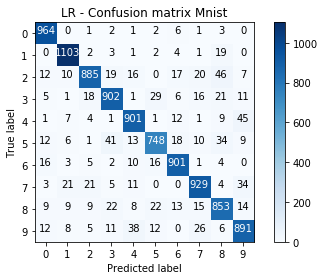

             precision    recall  f1-score   support

          0       0.93      0.98      0.96       980
          1       0.94      0.97      0.96      1135
          2       0.93      0.86      0.89      1032
          3       0.89      0.89      0.89      1010
          4       0.90      0.92      0.91       982
          5       0.90      0.84      0.87       892
          6       0.92      0.94      0.93       958
          7       0.91      0.90      0.91      1028
          8       0.85      0.88      0.86       974
          9       0.88      0.88      0.88      1009

avg / total       0.91      0.91      0.91     10000


Confusion Matrix

[[ 606    4  339   52  254  163   78   67  123  314]
 [ 196  333  153  293  250   91   38  400  230   16]
 [ 191   29 1183  134   65  113   93   97   73   21]
 [ 107    4  119 1246   22  294   20   80   67   41]
 [  43   85   38   48 1031  154   38  167  250  146]
 [ 164   21  192  158   39 1164  107   75   57   23]
 [ 316   13  363   86   

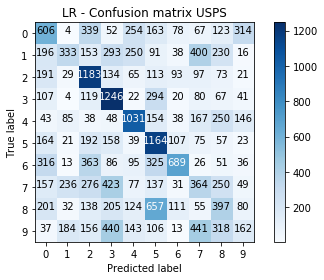

             precision    recall  f1-score   support

          0       0.30      0.30      0.30      2000
          1       0.35      0.17      0.23      2000
          2       0.40      0.59      0.48      1999
          3       0.40      0.62      0.49      2000
          4       0.49      0.52      0.50      2000
          5       0.36      0.58      0.45      2000
          6       0.57      0.34      0.43      2000
          7       0.21      0.18      0.19      2000
          8       0.22      0.20      0.21      2000
          9       0.18      0.08      0.11      2000

avg / total       0.35      0.36      0.34     19999



In [263]:
LOGRModel(100)

In [264]:
print("\n----------------ENSEMBLE CLASSIFIER------------------")
clf = np.vstack((clf1_m, clf2_m, clf3_m, clf4_m)).T
counter = 0
for i, arr in enumerate(clf):
    pred = np.argmax(np.bincount(arr))
    if(pred == test_data[1][i]):
        counter += 1
print("\nMNIST Accuracy = "+ str(float((counter*100))/clf.shape[0]))

clf = np.vstack((clf1_u, clf2_u, clf3_u, clf4_u)).T
counter = 0
for i, arr in enumerate(clf):
    pred = np.argmax(np.bincount(arr))
    if(pred == USPS_test_target[i]):
        counter += 1

print("\nUSPS Accuracy = "+ str(float((counter*100))/clf.shape[0]))


----------------ENSEMBLE CLASSIFIER------------------

MNIST Accuracy = 96.6

USPS Accuracy = 34.961748087404374
